Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.0 GB
Initialisiere Liquid State Machine...
Reservoir Größe: 1000
Trainierbare Parameter: 129418
Gefrorene Parameter: 1784000
Lade N-MNIST Daten...
N-MNIST nicht verfügbar, verwende normales MNIST...
MNIST erfolgreich geladen!
Starte Training...


Epoch 1/5: 100%|██████████| 938/938 [00:36<00:00, 25.62it/s, Loss=1.0136, GPU_Mem=0.0GB]


Epoch 1: Loss = 1.5913, Test Acc = 61.14%


Epoch 2/5: 100%|██████████| 938/938 [00:34<00:00, 26.87it/s, Loss=1.0193, GPU_Mem=0.0GB]


Epoch 2: Loss = 1.0642, Test Acc = 67.99%


Epoch 3/5: 100%|██████████| 938/938 [00:34<00:00, 27.30it/s, Loss=0.9630, GPU_Mem=0.0GB]


Epoch 3: Loss = 0.9153, Test Acc = 71.23%


Epoch 4/5: 100%|██████████| 938/938 [00:34<00:00, 27.36it/s, Loss=0.8628, GPU_Mem=0.0GB]


Epoch 4: Loss = 0.8360, Test Acc = 74.14%


Epoch 5/5: 100%|██████████| 938/938 [00:33<00:00, 27.66it/s, Loss=0.5785, GPU_Mem=0.0GB]


Epoch 5: Loss = 0.7884, Test Acc = 75.42%


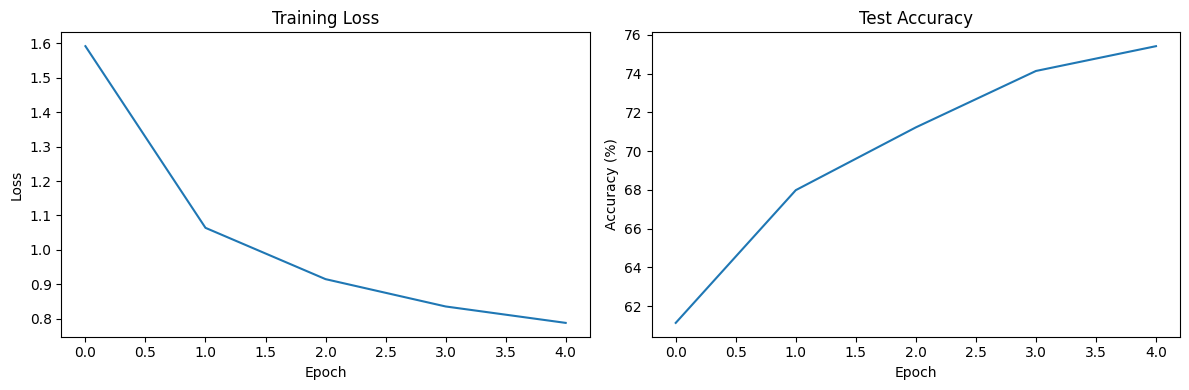

Finale Test-Genauigkeit: 75.42%
Training abgeschlossen!


In [3]:
# Liquid State Machine mit snnTorch und Tonic MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
from snntorch import surrogate
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    torch.cuda.empty_cache()  # Leere GPU Cache

# Hyperparameter
num_epochs = 5
batch_size = 64  # Erhöht für bessere GPU-Auslastung
learning_rate = 1e-3
num_steps = 50  # Reduziert für GPU Memory
input_size = 28 * 28
reservoir_size = 1000  # Erhöht für bessere Performance
output_size = 10
beta = 0.9  # LIF decay parameter

class LiquidReservoir(nn.Module):
    """Reservoir (Liquid) Teil der LSM"""
    def __init__(self, input_size, reservoir_size, connectivity=0.1, spectral_radius=0.9):
        super().__init__()
        
        self.reservoir_size = reservoir_size
        self.connectivity = connectivity
        
        # LIF Neuronen für das Reservoir
        self.lif = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        
        # Input-zu-Reservoir Verbindungen
        self.W_in = nn.Linear(input_size, reservoir_size, bias=False)
        
        # Rekurrente Reservoir-Verbindungen
        self.W_rec = nn.Linear(reservoir_size, reservoir_size, bias=False)
        
        # Reservoir-Gewichte initialisieren
        self._init_reservoir_weights(spectral_radius)
        
        # Reservoir-Gewichte einfrieren (nicht trainierbar)
        for param in self.parameters():
            param.requires_grad = False
    
    def _init_reservoir_weights(self, spectral_radius):
        """Initialisiere spärliche, zufällige Reservoir-Gewichte"""
        with torch.no_grad():
            # Input-Gewichte: uniform zwischen -1 und 1
            self.W_in.weight.uniform_(-1, 1)
            
            # Rekurrente Gewichte: spärlich und spektral normalisiert
            # Erstelle spärliche Maske
            mask = torch.rand(self.reservoir_size, self.reservoir_size) < self.connectivity
            
            # Zufällige Gewichte
            weights = torch.randn(self.reservoir_size, self.reservoir_size)
            weights *= mask.float()
            
            # Spektralradius normalisieren
            eigenvals = torch.linalg.eigvals(weights)
            current_spectral_radius = torch.max(torch.abs(eigenvals)).real
            
            if current_spectral_radius > 0:
                weights *= spectral_radius / current_spectral_radius
            
            self.W_rec.weight.data = weights
    
    def forward(self, x, mem):
        """Forward pass durch das Reservoir"""
        # Input + rekurrente Verbindungen
        cur_in = self.W_in(x)
        cur_rec = self.W_rec(mem)
        cur = cur_in + cur_rec
        
        # LIF Neuron Update - mem muss die richtige Dimension haben
        spk, mem = self.lif(cur, mem)
        return spk, mem
    
    def init_reservoir(self, batch_size):
        """Initialisiere Reservoir-Zustand"""
        return torch.zeros(batch_size, self.reservoir_size).to(device)

class LSM(nn.Module):
    """Komplette Liquid State Machine"""
    def __init__(self, input_size, reservoir_size, output_size):
        super().__init__()
        
        self.reservoir = LiquidReservoir(input_size, reservoir_size)
        
        # Readout Layer (nur dieser wird trainiert)
        self.readout = nn.Sequential(
            nn.Linear(reservoir_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
        
        # Optional: verwende finale Reservoir-Aktivität oder integrierte Aktivität
        self.use_integrated_activity = True
    
    def forward(self, x):
        """Forward pass durch die komplette LSM"""
        batch_size, num_steps, input_dim = x.shape
        
        # Reservoir-Zustand initialisieren
        mem = self.reservoir.init_reservoir(batch_size)
        
        if self.use_integrated_activity:
            # Integriere Reservoir-Aktivität über Zeit
            reservoir_activity = torch.zeros(batch_size, self.reservoir.reservoir_size).to(device)
            
            for step in range(num_steps):
                spk, mem = self.reservoir(x[:, step], mem)
                reservoir_activity += spk
            
            # Normalisiere durch Anzahl Zeitschritte
            reservoir_activity /= num_steps
        else:
            # Verwende nur finale Reservoir-Aktivität
            for step in range(num_steps):
                spk, mem = self.reservoir(x[:, step], mem)
            reservoir_activity = mem
        
        # Readout
        output = self.readout(reservoir_activity)
        return output

# Daten laden mit Tonic
def load_mnist_data():
    """Lade MNIST Daten mit Tonic"""
    # Transformationen
    transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(28, 28, 1), n_time_bins=num_steps),
        torch.from_numpy,
    ])
    
    # Datasets
    train_dataset = tonic.datasets.NMNIST(
        save_to='./data', 
        train=True, 
        transform=transform,
        download=True
    )
    
    test_dataset = tonic.datasets.NMNIST(
        save_to='./data', 
        train=False, 
        transform=transform,
        download=True
    )
    
    return train_dataset, test_dataset

# Alternative: Normales MNIST zu Spikes konvertieren
def create_spike_mnist():
    """Erstelle Spike-Version von normalem MNIST"""
    from torchvision import datasets, transforms as torch_transforms
    
    # Normale MNIST Daten laden
    transform = torch_transforms.Compose([
        torch_transforms.ToTensor(),
        torch_transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    return train_dataset, test_dataset

def mnist_to_spikes(data, labels, num_steps=50):
    """Konvertiere MNIST Bilder zu Spike-Trains"""
    batch_size = data.shape[0]
    
    # Normalisiere zu [0,1] für Rate-Encoding
    if data.min() < 0:  # Falls normalisiert zwischen [-1,1]
        data = (data + 1) / 2  # Von [-1,1] zu [0,1]
    else:  # Falls bereits zwischen [0,1]
        data = data.clamp(0, 1)
    
    data = data.view(batch_size, -1)  # Flatten
    
    # Rate-basierte Spike-Generierung direkt auf GPU
    spike_data = torch.zeros(batch_size, num_steps, input_size, device=data.device)
    
    for step in range(num_steps):
        # Bernoulli-Sampling basierend auf Pixel-Intensität
        prob = data.clamp(0, 1)
        spike_data[:, step, :] = torch.bernoulli(prob)
    
    return spike_data, labels

# Training Funktion
def train_model(model, train_loader, test_loader, num_epochs):
    """Trainiere die LSM"""
    optimizer = torch.optim.Adam(model.readout.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (data, targets) in enumerate(progress_bar):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            # Konvertiere zu Spikes falls nötig
            if len(data.shape) == 4:  # Normales MNIST
                spike_data, targets = mnist_to_spikes(data, targets, num_steps)
                spike_data = spike_data.to(device, non_blocking=True)
            else:  # Bereits Spike-Daten
                spike_data = data.float()
            
            # Forward pass
            outputs = model(spike_data)
            loss = criterion(outputs, targets)
            
            # Backward pass (nur Readout wird trainiert)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            # Update Progress Bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'GPU_Mem': f'{torch.cuda.memory_allocated()/1024**3:.1f}GB' if torch.cuda.is_available() else 'CPU'
            })
            
            # ENTFERNT: Keine Begrenzung mehr!
        
        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)
        
        # Test Accuracy
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Test Acc = {test_acc:.2f}%')
    
    return train_losses, test_accuracies

def evaluate_model(model, test_loader):
    """Evaluiere Modell auf Test-Daten"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            # Konvertiere zu Spikes falls nötig
            if len(data.shape) == 4:  # Normales MNIST
                spike_data, targets = mnist_to_spikes(data, targets, num_steps)
                spike_data = spike_data.to(device, non_blocking=True)
            else:  # Bereits Spike-Daten
                spike_data = data.float()
            
            outputs = model(spike_data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # ENTFERNT: Keine Begrenzung mehr für vollständige Evaluation!
    
    accuracy = 100 * correct / total
    return accuracy

# Main Execution
if __name__ == "__main__":
    print("Initialisiere Liquid State Machine...")
    
    # Modell erstellen
    model = LSM(input_size, reservoir_size, output_size).to(device)
    
    print(f"Reservoir Größe: {reservoir_size}")
    print(f"Trainierbare Parameter: {sum(p.numel() for p in model.readout.parameters())}")
    print(f"Gefrorene Parameter: {sum(p.numel() for p in model.reservoir.parameters())}")
    
    try:
        # Versuche N-MNIST zu laden
        print("Lade N-MNIST Daten...")
        train_dataset, test_dataset = load_mnist_data()
        print("N-MNIST erfolgreich geladen!")
    except:
        # Fallback zu normalem MNIST
        print("N-MNIST nicht verfügbar, verwende normales MNIST...")
        train_dataset, test_dataset = create_spike_mnist()
        print("MNIST erfolgreich geladen!")
    
    # DataLoader erstellen (mit GPU-optimierten Einstellungen)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,  # Parallele Datenladung
        pin_memory=True  # Schnellerer GPU Transfer
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    print("Starte Training...")
    
    # Training
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, num_epochs)
    
    # Ergebnisse plotten
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Finale Test-Genauigkeit: {test_accuracies[-1]:.2f}%")
    print("Training abgeschlossen!")